In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap

# Assuming df is your DataFrame after aggregating to daily data and merging with weather/building data
df = pd.read_csv("/kaggle/input/aob-sample-totalenergy/data_cut.csv")# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# Get the number of rows and columns 
# rows = len(df.axes[0]) 
# cols = len(df.axes[1]) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   time                               478 non-null    object 
 1   Comms and Services                 472 non-null    float64
 2   Car Chargers                       472 non-null    float64
 3   Space Heating                      472 non-null    float64
 4   Hot Water                          472 non-null    float64
 5   Sockets                            472 non-null    float64
 6   Lighting                           472 non-null    float64
 7   total_energy                       478 non-null    object 
 8   datepart                           478 non-null    int64  
 9   weekend                            478 non-null    bool   
 10  bank holiday                       478 non-null    bool   
 11  hour                               478 non-null    int64  

In [2]:
df.dropna(inplace=True)
# print(df.isnull().sum())
print(df.head(10))
df['total_energy'] = df['total_energy'].astype(float)
print(df.dtypes)

                       time  Comms and Services  Car Chargers  Space Heating  \
120  2019-04-06 00:00:00+00            0.588947      0.043317       0.975708   
121  2019-04-06 01:00:00+00            0.589767      0.043242       1.001172   
122  2019-04-06 02:00:00+00            0.589928      0.043292       0.958303   
127  2019-04-06 07:00:00+00            0.589178      0.042758       0.962289   
154  2019-04-07 10:00:00+00            0.591714      0.040911       0.947272   
155  2019-04-07 11:00:00+00            0.592839      0.040139       0.251039   
157  2019-04-07 13:00:00+00            0.592383      0.041172       0.241764   
158  2019-04-07 14:00:00+00            0.592697      0.041139       0.297269   
161  2019-04-07 17:00:00+00            0.592075      0.041367       0.905353   
162  2019-04-07 18:00:00+00            0.591469      0.041664       0.976436   

     Hot Water   Sockets  Lighting total_energy  datepart  weekend  ...  \
120        0.0  0.062994  0.194364  1.865330

In [3]:
# Group the data by 'hour' and calculate the average energy consumption for each hour
average_consumption_per_hour = df.groupby('hour')['total_energy'].mean().reset_index()

# Sort the results by energy consumption in descending order to find the hours with the most consumption
sorted_average_consumption = average_consumption_per_hour.sort_values(by='total_energy', ascending=False)

# Display the sorted average consumption
# print(sorted_average_consumption)
print(sorted_average_consumption.to_string(index=False))

 hour  total_energy
    8      7.866776
    9      7.663850
   12      7.195384
   10      6.621639
   11      6.531581
    7      5.397238
   13      4.906392
    6      4.721923
    5      4.401279
    4      4.244462
   14      3.962587
    3      3.945413
   15      3.901187
   16      3.628383
   17      2.728664
    2      2.680750
   18      2.526785
    0      1.835015
   19      1.783751
    1      1.758063
   22      1.743751
   23      1.735433
   21      1.691483
   20      1.679026


In [4]:
# Feature Engineering
# Add temporal features (e.g., day of week, month)
# df['Day of week'] = df['Day of week'].dt.dayofweek
# df['Month'] = df['Month'].dt.month

# Check if 'Weekend' is False
if df['weekend'].value_counts().get(False, 0):
    df['weekend'] = 0
else:
    df['weekend'] = 1

In [5]:
   
if df['bank holiday'].value_counts().get(True,1):
    
    df['bank holiday'] = 1
else:
    df['bank holiday'] = 0

In [6]:
df = df.drop(['Comms and Services','Car Chargers','Space Heating','Hot Water','Sockets', 'Lighting' ], axis = 1)
df.head(10)

,time,total_energy,datepart,weekend,bank holiday,hour,day of week,day of month,month,year,...,forecast_winddirection,forecast_visibility,forecast_interval,observationperiod,observation_temperature,observation_winddirection,observation_windspeed,observation_pressure,observation_dewpoint,observation_humidity
120,2019-04-06 00:00:00+00,1.865331,43561,0,1,0,6,6,4,2019,...,NE,VG,1 day,2019-04-06 00:00:00+00,8.5,NNE,13.0,1006.0,3.9,72.7
121,2019-04-06 01:00:00+00,1.838036,43561,0,1,1,6,6,4,2019,...,NE,VG,23:00:00,2019-04-06 01:00:00+00,8.3,NNE,11.0,1006.0,4.4,76.3
122,2019-04-06 02:00:00+00,1.800356,43561,0,1,2,6,6,4,2019,...,NE,VG,22:00:00,2019-04-06 02:00:00+00,7.8,NNE,13.0,1006.0,4.6,80.1
127,2019-04-06 07:00:00+00,1.791806,43561,0,1,7,6,6,4,2019,...,ENE,GO,23:00:00,2019-04-06 07:00:00+00,8.8,NE,14.0,1007.0,5.2,77.9
154,2019-04-07 10:00:00+00,1.789739,43562,0,1,10,0,7,4,2019,...,ESE,MO,23:00:00,2019-04-07 10:00:00+00,11.2,ENE,16.0,1008.0,6.4,72.1
155,2019-04-07 11:00:00+00,1.084692,43562,0,1,11,0,7,4,2019,...,ESE,MO,22:00:00,2019-04-07 11:00:00+00,11.9,E,10.0,1008.0,6.7,70.4
157,2019-04-07 13:00:00+00,1.071356,43562,0,1,13,0,7,4,2019,...,ESE,GO,23:00:00,2019-04-07 13:00:00+00,13.5,ESE,19.0,1008.0,8.1,69.7
158,2019-04-07 14:00:00+00,1.130494,43562,0,1,14,0,7,4,2019,...,ESE,GO,22:00:00,2019-04-07 14:00:00+00,11.2,ESE,14.0,1008.0,7.2,76.3
161,2019-04-07 17:00:00+00,2.103717,43562,0,1,17,0,7,4,2019,...,ESE,GO,22:00:00,2019-04-07 17:00:00+00,11.9,SE,15.0,1008.0,7.8,75.8
162,2019-04-07 18:00:00+00,1.884569,43562,0,1,18,0,7,4,2019,...,SE,GO,1 day,2019-04-07 18:00:00+00,11.9,E,13.0,1008.0,7.9,76.4


In [7]:
unique_values = df['forecast_winddirection'].unique()
print("number of unique values: ", len(unique_values), "Unique values in the column:")
for value in unique_values:
    print(value)

number of unique values:  14 Unique values in the column:
NE
ENE
ESE
SE
E
NNE
N
SSE
SSW
NW
S
SW
WNW
WSW


### One potential analysis is to understand which wind directions had less or more consumption or alternatively statistically proven that they do not affect the results so they can be removed. 

In [8]:
unique_values = df['forecast_visibility'].unique()
print("number of unique values: ", len(unique_values), "Unique values in the column:")
for value in unique_values:
    print(value)

number of unique values:  5 Unique values in the column:
VG
GO
MO
EX
PO


In [9]:
unique_values = df['observation_winddirection'].unique()
print("number of unique values: ", len(unique_values), "Unique values in the column:")
for value in unique_values:
    print(value)

number of unique values:  15 Unique values in the column:
NNE
NE
ENE
E
ESE
SE
SSE
SSW
S
SW
N
WSW
W
WNW
NNW


### High degree of variability between observational and forecast even the wind directions have different values let alone discrepancies in the data. 

Linear Regression RMSE: 3.7995152265953345
Random Forest RMSE: 5.107990462387459


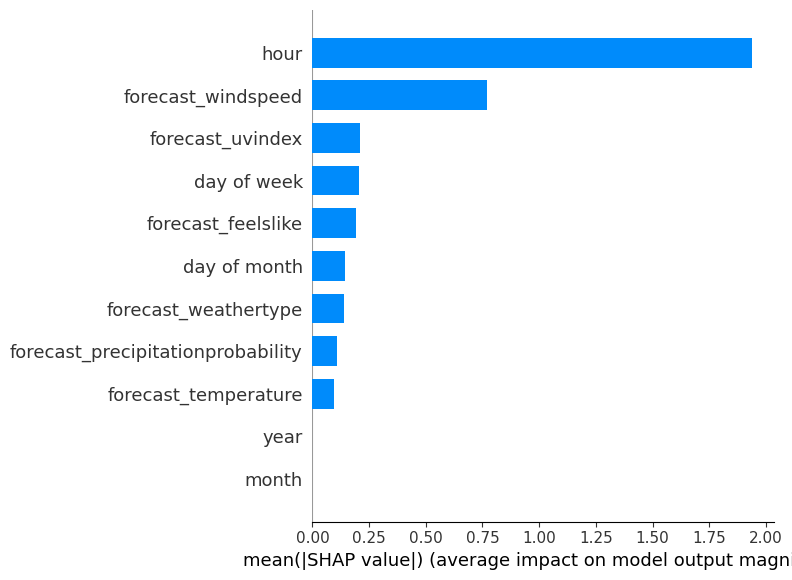

In [10]:
# Split data into features and target
X = df.drop(['total_energy'], axis=1)  # Assuming 'energy_consumption' is the target variable
y = df['total_energy']
X = X[['forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','hour' , 'day of week','day of month' ,'month','year']] 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model Training
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

# Model Evaluation
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

# Feature Importance Analysis with SHAP for Random Forest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

# Replace the model training and evaluation code with your model of choice and adjust the feature engineering 
# and data preparation steps based on your dataset specifics.

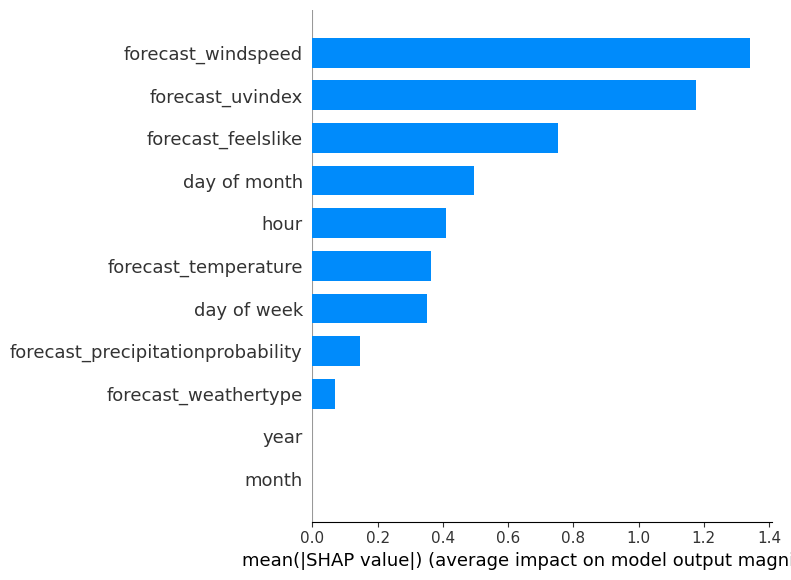

In [11]:
# Assuming 'model' is your trained linear regression model
# and 'X_train' is your training dataset

# Initialize the explainer
explainer = shap.LinearExplainer(lr_model, X_train)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [12]:
import pandas as pd

# Define your future time range
future_dates = pd.date_range(start='2024-01-01', end='2024-01-31', freq='H')  # Example for January 2024

# Create a DataFrame
future_df = pd.DataFrame(future_dates, columns=['date'])
future_df['hour'] = future_df['date'].dt.hour
future_df['month'] = future_df['date'].dt.month
future_df['year'] = future_df['date'].dt.year


# Add additional features as needed, e.g., weather predictions
# future_df[]
# future_df['temperature'] = ...


In [13]:
# Add missing columns with placeholder or estimated values
required_columns = ['forecast_temperature','forecast_feelslike','forecast_weathertype','forecast_precipitationprobability','forecast_windspeed', 'forecast_uvindex','hour' , 'day of week','day of month' ,'month','year']
for col in required_columns:
    if col not in future_df.columns:
        future_df[col] = 0  # Or use a more appropriate placeholder/estimation method

# Ensure column order matches the training data
# Assuming 'train_columns' is a list of column names in the order they were in during training
future_df = future_df[required_columns]

# Retry prediction
predictions = lr_model.predict(future_df)

# Add predictions back to your DataFrame
# future_df['total_energy'] = predictions

# Create model_future_df from future_df
lrmodel_future_df = future_df.copy()

# Add the 'total_energy' column from predictions
lrmodel_future_df['total_energy'] = predictions

In [14]:
lrmodel_future_df

,forecast_temperature,forecast_feelslike,forecast_weathertype,forecast_precipitationprobability,forecast_windspeed,forecast_uvindex,hour,day of week,day of month,month,year,total_energy
0,0,0,0,0,0,0,0,0,0,1,2024,9.177000
1,0,0,0,0,0,0,1,0,0,1,2024,9.110266
2,0,0,0,0,0,0,2,0,0,1,2024,9.043531
3,0,0,0,0,0,0,3,0,0,1,2024,8.976797
4,0,0,0,0,0,0,4,0,0,1,2024,8.910062
...,...,...,...,...,...,...,...,...,...,...,...,...
716,0,0,0,0,0,0,20,0,0,1,2024,7.842310
717,0,0,0,0,0,0,21,0,0,1,2024,7.775575
718,0,0,0,0,0,0,22,0,0,1,2024,7.708840
719,0,0,0,0,0,0,23,0,0,1,2024,7.642106


In [15]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the model
gbr_model = GradientBoostingRegressor()

# Fit the model
gbr_model.fit(X_train, y_train)
# future_df =  future_df.drop(['date'], axis = 1)
# Predict on future data
predictions_gbr = gbr_model.predict(future_df)
# print(predictions_gbr)
gbrmodel_future_df = future_df.copy()

# # Add the 'total_energy' column from predictions
gbrmodel_future_df['total_energy'] = predictions_gbr


In [16]:
gbrmodel_future_df

,forecast_temperature,forecast_feelslike,forecast_weathertype,forecast_precipitationprobability,forecast_windspeed,forecast_uvindex,hour,day of week,day of month,month,year,total_energy
0,0,0,0,0,0,0,0,0,0,1,2024,8.036442
1,0,0,0,0,0,0,1,0,0,1,2024,8.031536
2,0,0,0,0,0,0,2,0,0,1,2024,9.301083
3,0,0,0,0,0,0,3,0,0,1,2024,10.359105
4,0,0,0,0,0,0,4,0,0,1,2024,10.765574
...,...,...,...,...,...,...,...,...,...,...,...,...
716,0,0,0,0,0,0,20,0,0,1,2024,6.907446
717,0,0,0,0,0,0,21,0,0,1,2024,6.907446
718,0,0,0,0,0,0,22,0,0,1,2024,6.907446
719,0,0,0,0,0,0,23,0,0,1,2024,6.907446


In [17]:
# Retry prediction
predictions_gbr = gbr_model.predict(X_test)

# Add predictions back to your DataFrame
# future_df['total_energy'] = predictions
print("Gradient Boosting Regression RMSE:", np.sqrt(mean_squared_error(y_test, predictions_gbr)))

# Create model_future_df from future_df
# lrmodel_future_df = future_df.copy()

# # Add the 'total_energy' column from predictions
# lrmodel_future_df['total_energy'] = predictions

Gradient Boosting Regression RMSE: 4.800663832250519


In [18]:
from sklearn.svm import SVR

# Initialize the model
svr_model = SVR()

# Fit the model
svr_model.fit(X_train, y_train)
predictions_svr0 = svr_model.predict(X_test)

# Add predictions back to your DataFrame
# future_df['total_energy'] = predictions
print("Support Vector Regression RMSE:", np.sqrt(mean_squared_error(y_test, predictions_svr0)))

# Predict on future data
predictions_svr = svr_model.predict(future_df)

svrmodel_future_df = future_df.copy()

# # Add the 'total_energy' column from predictions
svrmodel_future_df['total_energy'] = predictions_svr


Support Vector Regression RMSE: 4.104454631071298


In [19]:
svrmodel_future_df.head(48)

,forecast_temperature,forecast_feelslike,forecast_weathertype,forecast_precipitationprobability,forecast_windspeed,forecast_uvindex,hour,day of week,day of month,month,year,total_energy
0,0,0,0,0,0,0,0,0,0,1,2024,2.200905
1,0,0,0,0,0,0,1,0,0,1,2024,2.200683
2,0,0,0,0,0,0,2,0,0,1,2024,2.200460
3,0,0,0,0,0,0,3,0,0,1,2024,2.200237
4,0,0,0,0,0,0,4,0,0,1,2024,2.200014
5,0,0,0,0,0,0,5,0,0,1,2024,2.199791
6,0,0,0,0,0,0,6,0,0,1,2024,2.199569
7,0,0,0,0,0,0,7,0,0,1,2024,2.199346
8,0,0,0,0,0,0,8,0,0,1,2024,2.199123
9,0,0,0,0,0,0,9,0,0,1,2024,2.198900


In [20]:
from sklearn.linear_model import Ridge

# Initialize the model
ridge_model = Ridge()

# Fit the model
ridge_model.fit(X_train, y_train)
predictions_ridge0 = ridge_model.predict(X_test)

# Add predictions back to your DataFrame
# future_df['total_energy'] = predictions
print("Ridge Regression RMSE:", np.sqrt(mean_squared_error(y_test, predictions_ridge0)))

# Predict on future data
predictions_ridge = ridge_model.predict(future_df)

ridgemodel_future_df = future_df.copy()

# # Add the 'total_energy' column from predictions
ridgemodel_future_df['total_energy'] = predictions_ridge


Ridge Regression RMSE: 3.7998687219779335


In [21]:
ridgemodel_future_df.head(48)

,forecast_temperature,forecast_feelslike,forecast_weathertype,forecast_precipitationprobability,forecast_windspeed,forecast_uvindex,hour,day of week,day of month,month,year,total_energy
0,0,0,0,0,0,0,0,0,0,1,2024,9.171902
1,0,0,0,0,0,0,1,0,0,1,2024,9.105078
2,0,0,0,0,0,0,2,0,0,1,2024,9.038253
3,0,0,0,0,0,0,3,0,0,1,2024,8.971429
4,0,0,0,0,0,0,4,0,0,1,2024,8.904605
5,0,0,0,0,0,0,5,0,0,1,2024,8.837781
6,0,0,0,0,0,0,6,0,0,1,2024,8.770956
7,0,0,0,0,0,0,7,0,0,1,2024,8.704132
8,0,0,0,0,0,0,8,0,0,1,2024,8.637308
9,0,0,0,0,0,0,9,0,0,1,2024,8.570483


In [22]:
from sklearn.linear_model import Lasso

# Initialize the model
lasso_model = Lasso()

# Fit the model
lasso_model.fit(X_train, y_train)
predictions_lasso0 = lasso_model.predict(X_test)

# Add predictions back to your DataFrame
# future_df['total_energy'] = predictions
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, predictions_lasso0)))

# Predict on future data
predictions_lasso = lasso_model.predict(future_df)

lassomodel_future_df = future_df.copy()

# # Add the 'total_energy' column from predictions
lassomodel_future_df['total_energy'] = predictions_lasso



Lasso RMSE: 4.046444069353259


In [23]:
lassomodel_future_df.head(48)

,forecast_temperature,forecast_feelslike,forecast_weathertype,forecast_precipitationprobability,forecast_windspeed,forecast_uvindex,hour,day of week,day of month,month,year,total_energy
0,0,0,0,0,0,0,0,0,0,1,2024,6.236072
1,0,0,0,0,0,0,1,0,0,1,2024,6.140963
2,0,0,0,0,0,0,2,0,0,1,2024,6.045854
3,0,0,0,0,0,0,3,0,0,1,2024,5.950746
4,0,0,0,0,0,0,4,0,0,1,2024,5.855637
5,0,0,0,0,0,0,5,0,0,1,2024,5.760528
6,0,0,0,0,0,0,6,0,0,1,2024,5.665420
7,0,0,0,0,0,0,7,0,0,1,2024,5.570311
8,0,0,0,0,0,0,8,0,0,1,2024,5.475203
9,0,0,0,0,0,0,9,0,0,1,2024,5.380094


In [24]:
# # Assuming 'model' is your trained regression model
# predictions = lr_model.predict(future_df.drop('date', axis=1))  # Drop 'date' if it's not used directly by your model

# # Add predictions back to your DataFrame
# future_df['predicted_energy_consumption'] = predictions


It’s worth noting that a regression problem can be converted into a classification problem by simply discretizing the response variable into buckets.

In [25]:
#Lime